In [17]:
from mylib.statistic_test import *
from mylib.statistic_test import GetMultidayIndexmap, ReadCellReg
from mylib.multiday.core import MultiDayCore

code_id = "0313 - Conditional Probability for Field Maintain"
loc = join(figpath, code_id)
mkdir(loc)
sfn_loc = join(figpath, "SfN Poster", code_id)
mkdir(sfn_loc)

# This step is to call function `ConditionalProb_Interface` to calculate 
# the conditional probabilities for all spatial maps.

if os.path.exists(join(figdata, f'{code_id}.pkl')):
    with open(join(figdata, f'{code_id}.pkl'), 'rb') as handle:
        Data = pickle.load(handle)
else:
    Data = DataFrameEstablish(
        variable_names = [
            'Duration', 'Conditional Prob.', 'Conditional Recover Prob.',
            'Global Recover Prob.', 'Cumulative Prob.', 'Paradigm', 
            'On-Next Num', 'Off-Next Num'
        ], 
        f_member=['Type'], f = f_CellReg_modi, 
        function = ConditionalProb_Interface, 
        file_name = code_id, behavior_paradigm = 'CrossMaze'
    )

        D:\Data\FinalResults\0313 - Conditional Probability for Field Maintain is already existed!
        D:\Data\FinalResults\SfN Poster\0313 - Conditional Probability for Field Maintain is already existed!


# Fit Empirical Curves

In [ ]:
from scipy.optimize import curve_fit
def exp_func(x, k, b):
    return 1 - np.exp(-k * (x-b))

def polynomial_converge2(x, k, b, c):
    return c - 1 / (k*x + b)

def kww_decay(x, a, b, c):
    return a*np.exp(-np.power(x/b, c))

def report_para(Data, name: str = 'KWW', key: str = 'Conditional Prob.'):
    """
    Report the fitted parameters for specified function.
    """
    mazes = ['Maze 1', 'Maze 2']
    mice = [10209, 10212, 10224, 10227, 10232, 10234]
    
    if name == 'KWW':
        params = [[], [], []]
    elif name == 'exp':
        params = [[], []]
    elif name == 'poly':
        params = [[], [], []]

    for maze in mazes:
        idx = np.where((Data['Paradigm'] == 'CrossMaze')&
                       (Data['Maze Type'] == maze)&
                       (np.isnan(Data[key]) == False))[0]
        if len(idx) == 0:
            continue
        if name == 'KWW':
            params0, _ = curve_fit(kww_decay, 
                                   Data['Duration'][idx], 
                                   Data[key][idx]/100)
            params[0].append(params0[0])
            params[1].append(params0[1])
        elif name == 'exp':
            params0, _ = curve_fit(exp_func, 
                                   Data['Duration'][idx], 
                                   Data[key][idx]/100)
            params[0].append(params0[0])
            params[1].append(params0[1])
        elif name == 'poly':
            bounds = ([0, -np.inf, 0], [np.inf, np.inf, 1])
            params0, _ = curve_fit(polynomial_converge2, 
                                   Data['Duration'][idx], 
                                   Data[key][idx]/100, 
                                   bounds=bounds)
            params[0].append(params0[0])
            params[1].append(params0[1])
            params[2].append(params0[2])
                
    if name == 'KWW':
        print("KWW fitted parameters for all mice and both mazes -------------------------------")
        print("  b: ", np.mean(params[1]), np.std(params[1]))
        print("           ", params[1])
        print("  c: ", np.mean(params[2]), np.std(params[2]))
        print("           ", params[2], end='\n\n')
    elif name == 'exp':
        print("exp fitted parameters for all mice and both mazes -------------------------------")
        print("  k: ", np.mean(params[0]), np.std(params[0]))
        print("           ", params[0])
        print("  x0: ", np.mean(params[1]), np.std(params[1]))
        print("           ", params[1], end='\n\n')
    elif name == 'poly':
        print("poly fitted parameters for all mice and both mazes -------------------------------")
        print("  k: ", np.mean(params[0]), np.std(params[0]))
        print("           ", params[0])
        print("  b: ", np.mean(params[1]), np.std(params[1]))
        print("           ", params[1])
        print("  c: ", np.mean(params[2]), np.std(params[2]))
        print("           ", params[2], end='\n\n')

colors = sns.color_palette("rocket", 3)[1:]
markercolors = [sns.color_palette("Blues", 3)[1], sns.color_palette("Blues", 3)[2]]
chancecolors = ['#D4C9A8', '#8E9F85', '#C3AED6', '#FED7D7']

# Fit for Maze A and B (Retention Probability)

In [25]:
#Data['hue'] = np.array([Data['Papadigm'][i] + ' ' + Data['Maze Type'][i] for i in range(Data['Duration'].shape[0])])
idx = np.where((Data['Paradigm'] == 'CrossMaze')&
               (np.isnan(Data['Conditional Prob.']) == False)&
               (Data['Maze Type'] != 'Open Field')&
               (Data['Type'] == 'Real'))[0]
SubData = SubDict(Data, Data.keys(), idx=idx)

report_para(SubData, name='poly', key='Conditional Prob.')
report_para(SubData, name='exp', key='Conditional Prob.')
report_para(SubData, name='KWW', key='Conditional Recover Prob.')

idx1 = np.where(SubData['Maze Type'] == 'Maze 1')[0]
idx2 = np.where(SubData['Maze Type'] == 'Maze 2')[0]

initial_guesses = [0.9, 10, 0.5]  # Adjust these based on your data
# Bounds for the parameters: a between 0 and 1, b positive, c between 0 and 1
bounds = ([0, -np.inf, 0], [np.inf, np.inf, 1])
params1, _ = curve_fit(polynomial_converge2, 
                       SubData['Duration'][idx1], 
                       SubData['Conditional Prob.'][idx1]/100, 
                       bounds=bounds)
x1 = np.linspace(min(SubData['Duration'][idx1]), max(SubData['Duration'][idx1]), 10000)
print(params1)
params2, _ = curve_fit(polynomial_converge2, 
                       SubData['Duration'][idx2], 
                       SubData['Conditional Prob.'][idx2]/100, 
                       bounds=bounds)
x2 = np.linspace(min(SubData['Duration'][idx2]), max(SubData['Duration'][idx2]), 10000)
print(params2)

k1, b1, c1 = params1
k2, b2, c2 = params2

y1 = polynomial_converge2(x1, k1, b1, c1)
y2 = polynomial_converge2(x2, k2, b2, c2)

poly fitted parameters for all mice and both mazes -------------------------------
  k:  1.0962394578885672 0.013311251641314858
            [1.109550709529882, 1.0829282062472523]
  b:  0.9578525756630765 0.04134935368138942
            [0.9165032219816871, 0.9992019293444659]
  c:  0.9905741038244755 0.008247132936702484
            [0.998821236761178, 0.982326970887773]

exp fitted parameters for all mice and both mazes -------------------------------
  k:  0.2117414510176523 0.00834942484149219
            [0.2200908758591445, 0.20339202617616012]
  x0:  -2.910104776957155 0.11784276433510965
            [-2.792262012622045, -3.0279475412922645]

KWW fitted parameters for all mice and both mazes -------------------------------
  b:  0.5098691525523412 0.29872130793295215
            [0.21114784461938912, 0.8085904604852934]
  c:  nan nan
            []

[1.10955071 0.91650322 0.99882124]
[1.08292821 0.99920193 0.98232697]


C:\Users\12454\AppData\Local\Temp\ipykernel_25976\3093491739.py:9: RuntimeWarning: invalid value encountered in power
  return a*np.exp(-np.power(x/b, c))
d:\SoftwareData\Anaconda\envs\maze\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\SoftwareData\Anaconda\envs\maze\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\SoftwareData\Anaconda\envs\maze\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\SoftwareData\Anaconda\envs\maze\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
d:\SoftwareData\Anaconda\envs\maze\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encoun

# Visualize Fig. 4C

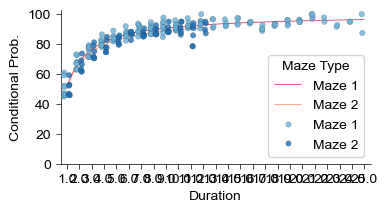

In [26]:
fig = plt.figure(figsize=(4, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)

ax.plot(x1-1, y1*100, color=colors[0], label='Maze 1', linewidth = 0.5)
ax.plot(x2-1, y2*100, color=colors[1], label='Maze 2', linewidth = 0.5)
sns.stripplot(
    x = 'Duration',
    y = 'Conditional Prob.',
    data=SubData,
    hue = "Maze Type",
    palette = markercolors,
    edgecolor='black',
    size=4,
    linewidth=0.1,
    alpha=0.8,
    ax = ax,
    dodge=True,
    jitter=0.1
)
ax.set_ylim(0, 103)
ax.set_yticks(np.linspace(0, 100, 6))
#plt.savefig(join(sfn_loc, "conditional prob.svg"))
plt.savefig(join(loc, 'Conditional prob.png'), dpi = 600)
plt.savefig(join(loc, 'Conditional prob.svg'), dpi = 600)
plt.show()

# Fit for Maze A and B (Recovery Probability)

In [27]:
idx = np.where((Data['Paradigm'] == 'CrossMaze')&
               (np.isnan(Data['Conditional Recover Prob.']) == False)&
               (Data['Maze Type'] != 'Open Field')&
               (Data['Type'] == 'Real'))[0]
SubData = SubDict(Data, Data.keys(), idx=idx)

idx = np.where((Data['Paradigm'] == 'CrossMaze')&
               (np.isnan(Data['Conditional Recover Prob.']) == False)&
               (Data['Maze Type'] != 'Open Field')&
               (Data['Type'] == 'Shuffle'))[0]
ShufData = SubDict(Data, Data.keys(), idx=idx)
idx1 = np.where(SubData['Maze Type'] == 'Maze 1')[0]
idx2 = np.where(SubData['Maze Type'] == 'Maze 2')[0]
params1, _ = curve_fit(kww_decay, SubData['Duration'][idx1], SubData['Conditional Recover Prob.'][idx1]/100)
print("Conditional Recovery prob. -----------------------------------------")
x1 = np.linspace(min(SubData['Duration'][idx1]), max(SubData['Duration'][idx1]), 10000)
print("Maze 1", params1)
params2, _ = curve_fit(kww_decay, SubData['Duration'][idx2], SubData['Conditional Recover Prob.'][idx2]/100)
x2 = np.linspace(min(SubData['Duration'][idx2]), max(SubData['Duration'][idx2]), 10000)
print("Maze 2", params2)

y1 = kww_decay(x1, *params1)
y2 = kww_decay(x2, *params2)

Conditional Recovery prob. -----------------------------------------
Maze 1 [1.69290848 0.23682905 0.3823063 ]
Maze 2 [0.85685693 0.80859046 0.54442646]


C:\Users\12454\AppData\Local\Temp\ipykernel_25976\3093491739.py:9: RuntimeWarning: invalid value encountered in power
  return a*np.exp(-np.power(x/b, c))


# Fig. 4G

C:\Users\12454\AppData\Local\Temp\ipykernel_25976\1604852571.py:18: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(


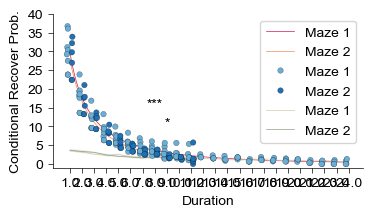

Maze A&B Conditional Recovery Prob. -----------------------------------------
Day  1
TtestResult(statistic=18.90685370562289, pvalue=7.710414347295741e-11, df=13)
Day  2
TtestResult(statistic=16.232323662702, pvalue=5.19273881729107e-10, df=13)
Day  3
TtestResult(statistic=14.574136286225844, pvalue=1.9684777647218093e-09, df=13)
Day  4
TtestResult(statistic=9.668219420343672, pvalue=2.6575902203400336e-07, df=13)
Day  5
TtestResult(statistic=10.953539044029748, pvalue=6.192899537383011e-08, df=13)
Day  6
TtestResult(statistic=8.264414286162912, pvalue=1.5635664343441234e-06, df=13)
Day  7
TtestResult(statistic=6.842775796249849, pvalue=1.1831785441860449e-05, df=13)
Day  8
TtestResult(statistic=4.570358649791869, pvalue=0.0005252823243594647, df=13)
Day  9
TtestResult(statistic=2.763560186083253, pvalue=0.01611475920032217, df=13)
Day  10
TtestResult(statistic=1.3568508043756986, pvalue=0.1979224609645682, df=13)
Day  11
TtestResult(statistic=1.7061680079524082, pvalue=0.1136997559791

In [34]:
fig = plt.figure(figsize=(4,2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax.plot(x1-1, y1*100, color=colors[0], label='Maze 1', linewidth = 0.5)
ax.plot(x2-1, y2*100, color=colors[1], label='Maze 2', linewidth = 0.5)
sns.stripplot(
    x = 'Duration',
    y = 'Conditional Recover Prob.',
    data=SubData,
    hue = "Maze Type",
    palette = markercolors,
    edgecolor='black',
    size=4,
    linewidth=0.15,
    ax = ax,
    dodge=True,
    jitter=0.1
)
sns.lineplot(
    x = ShufData['Duration']-1,
    y = ShufData['Conditional Recover Prob.'],
    hue = ShufData['Maze Type'],
    palette = chancecolors,
    linewidth = 0.5,
    err_kws={"edgecolor": None},
    ax = ax
)
ax.set_ylim(-1, 40)
ax.set_yticks(np.linspace(0, 40, 9))
ax.text(7, 15, "***", ha='center')
ax.text(8, 10, "*", ha='center')
plt.savefig(join(loc, 'Conditional recover prob.png'), dpi = 600)
plt.savefig(join(loc, 'Conditional recover prob.svg'), dpi = 600)
plt.show()

print("Maze A&B Conditional Recovery Prob. -----------------------------------------")
for i in range(1, 25):
    print("Day ",i)
    print(ttest_rel(SubData['Conditional Recover Prob.'][SubData['Duration'] == i], 
                    ShufData['Conditional Recover Prob.'][ShufData['Duration'] == i]))
print()

# Retention for ReverseMaze & HairpinMaze Fig. 4D

In [39]:
idx = np.where((Data['Paradigm'] != 'CrossMaze')&
               (np.isnan(Data['Conditional Prob.']) == False)&
               (Data['Type'] == 'Real'))[0]
SubData = SubDict(Data, Data.keys(), idx=idx)

# Fit parameters
idx = np.where(SubData['Paradigm'] == 'HairpinMaze cis')[0]
params1, _ = curve_fit(polynomial_converge2, SubData['Duration'][idx], SubData['Conditional Prob.'][idx]/100, bounds=bounds)
x1 = np.linspace(min(SubData['Duration'][idx]), max(SubData['Duration'][idx]), 10000)
print("Hairpin&Reverse Conditional Prob.")
print(params1)
y1 = polynomial_converge2(x1, *params1)

idx = np.where(SubData['Paradigm'] == 'HairpinMaze trs')[0]
params2, _ = curve_fit(polynomial_converge2, SubData['Duration'][idx], SubData['Conditional Prob.'][idx]/100, bounds=bounds)
x2 = np.linspace(min(SubData['Duration'][idx]), max(SubData['Duration'][idx]), 10000)
print(params2)
y2 = polynomial_converge2(x2, *params2)

idx = np.where(SubData['Paradigm'] == 'ReverseMaze cis')[0]
params3, _ = curve_fit(polynomial_converge2, SubData['Duration'][idx], SubData['Conditional Prob.'][idx]/100, bounds=bounds)
x3 = np.linspace(min(SubData['Duration'][idx]), max(SubData['Duration'][idx]), 10000)
print(params3)
y3 = polynomial_converge2(x3, *params3)

idx = np.where(SubData['Paradigm'] == 'ReverseMaze trs')[0]
params4, _ = curve_fit(polynomial_converge2, SubData['Duration'][idx], SubData['Conditional Prob.'][idx]/100, bounds=bounds)
x4 = np.linspace(min(SubData['Duration'][idx]), max(SubData['Duration'][idx]), 10000)
print(params4)
y4 = polynomial_converge2(x4, *params4)

Hairpin&Reverse Conditional Prob.
[1.30699547 0.63849022 0.93201704]
[0.95239468 0.89509473 0.94284111]
[1.39783147 0.68779354 1.        ]
[1.14715821 0.84328182 0.98799054]


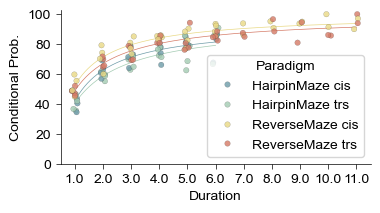

In [40]:
fig = plt.figure(figsize=(4, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
colors = ['#6D9BA8', '#A3CBB2', '#E9D985', '#D57A66']
ax.plot(x1-1, y1*100, color=colors[0], linewidth = 0.5)
ax.plot(x2-1, y2*100, color=colors[1], linewidth = 0.5)
ax.plot(x3-1, y3*100, color=colors[2], linewidth = 0.5)
ax.plot(x4-1, y4*100, color=colors[3], linewidth = 0.5)
sns.stripplot(
    x = 'Duration',
    y = 'Conditional Prob.',
    data=SubData,
    hue = "Paradigm",
    hue_order=['HairpinMaze cis', 'HairpinMaze trs', 'ReverseMaze cis', 'ReverseMaze trs'],
    palette = colors,
    edgecolor='black',
    size=4,
    linewidth=0.1,
    alpha=0.8,
    ax = ax,
    jitter=0.1
)
ax.set_ylim(0, 103)
ax.set_yticks(np.linspace(0, 100, 6))
plt.savefig(join(loc, '[Hairpin & Reverse] Conditional prob.png'), dpi = 600)
plt.savefig(join(loc, '[Hairpin & Reverse] Conditional prob.svg'), dpi = 600)
plt.show()

# Fit for Recovery Probability for ReverseMaze & HairpinMaze (Fig. 4H)

In [43]:
idx = np.where((Data['Paradigm'] != 'CrossMaze')&
               (np.isnan(Data['Conditional Recover Prob.']) == False)&
               (Data['Type'] == 'Real'))[0]
SubData = SubDict(Data, Data.keys(), idx=idx)

idx = np.where((Data['Paradigm'] != 'CrossMaze')&
               (np.isnan(Data['Conditional Recover Prob.']) == False)&
               (Data['Type'] == 'Shuffle'))[0]
ShufData = SubDict(Data, Data.keys(), idx=idx)

# Fit parameters
bounds = [[0, 0, 0], [np.inf, np.inf, np.inf]]
initial_guesses = [2, 0.1, 0.35]
idx = np.where(SubData['Paradigm'] == 'HairpinMaze cis')[0]
params1, _ = curve_fit(lambda x, b, c: kww_decay(x, 1, b, c), SubData['Duration'][idx], 
                       SubData['Conditional Recover Prob.'][idx]/100, p0=[0.1, 0.35])
x1 = np.linspace(min(SubData['Duration'][idx]), max(SubData['Duration'][idx]), 10000)
print(params1)
y1 = kww_decay(x1, 1, *params1)

idx = np.where(SubData['Paradigm'] == 'HairpinMaze trs')[0]
params2, _ = curve_fit(lambda x, b, c: kww_decay(x, 1, b, c), SubData['Duration'][idx], 
                       SubData['Conditional Recover Prob.'][idx]/100, p0=[0.1, 0.35])
x2 = np.linspace(min(SubData['Duration'][idx]), max(SubData['Duration'][idx]), 10000)
print(params2)
y2 = kww_decay(x2, 1, *params2)

idx = np.where(SubData['Paradigm'] == 'ReverseMaze cis')[0]
params3, _ = curve_fit(lambda x, b, c: kww_decay(x, 1, b, c), SubData['Duration'][idx], 
                       SubData['Conditional Recover Prob.'][idx]/100, p0=[0.1, 0.35])
x3 = np.linspace(min(SubData['Duration'][idx]), max(SubData['Duration'][idx]), 10000)
print(params3)
y3 = kww_decay(x3, 1, *params3)

idx = np.where(SubData['Paradigm'] == 'ReverseMaze trs')[0]
params4, _ = curve_fit(lambda x, b, c: kww_decay(x, 1, b, c), SubData['Duration'][idx], 
                       SubData['Conditional Recover Prob.'][idx]/100, p0=[0.1, 0.35])
x4 = np.linspace(min(SubData['Duration'][idx]), max(SubData['Duration'][idx]), 10000)
print(params4)
y4 = kww_decay(x4, 1, *params4)

[0.38063737 0.45981362]
[0.38786995 0.49624079]
[0.48622433 0.50267941]
[0.42023699 0.47939663]


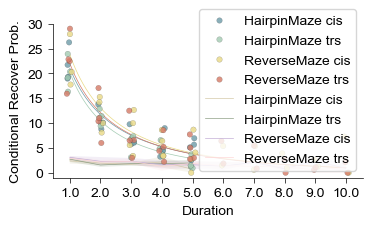

HP & MA reversed paradigms - Recovery Statistic Test
Day  1
TtestResult(statistic=16.69268480289537, pvalue=4.2529292273223785e-11, df=15)
Day  2
TtestResult(statistic=14.27450361137959, pvalue=3.900553247386827e-10, df=15)
Day  3
TtestResult(statistic=7.153236141508144, pvalue=3.3193027133222305e-06, df=15)
Day  4
TtestResult(statistic=10.19881219081679, pvalue=3.854311630915697e-08, df=15)
Day  5
TtestResult(statistic=3.409432138050629, pvalue=0.0038819194066257116, df=15)
Day  6
TtestResult(statistic=3.09405561441211, pvalue=0.05354359457066393, df=3)
Day  7
TtestResult(statistic=1.1655628111948415, pvalue=0.32803641328540656, df=3)
Day  8
TtestResult(statistic=1.3440614835841591, pvalue=0.27153423684323696, df=3)
Day  9
TtestResult(statistic=-0.32221841737644297, pvalue=0.7684357494160696, df=3)
Day  10
TtestResult(statistic=1.0210775837777746, pvalue=0.3823782314916928, df=3)



In [47]:
fig = plt.figure(figsize=(4, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
colors = ['#6D9BA8', '#A3CBB2', '#E9D985', '#D57A66']
ax.plot(x1-1, y1*100, color=colors[0], linewidth = 0.5)
ax.plot(x2-1, y2*100, color=colors[1], linewidth = 0.5)
ax.plot(x3-1, y3*100, color=colors[2], linewidth = 0.5)
ax.plot(x4-1, y4*100, color=colors[3], linewidth = 0.5)

sns.stripplot(
    x = 'Duration',
    y = 'Conditional Recover Prob.',
    data=SubData,
    hue = "Paradigm",
    hue_order=['HairpinMaze cis', 'HairpinMaze trs', 'ReverseMaze cis', 'ReverseMaze trs'],
    palette = colors,
    edgecolor='black',
    size=4,
    linewidth=0.1,
    alpha=0.8,
    ax = ax,
    jitter=0.1
)
sns.lineplot(
    x = ShufData['Duration']-1,
    y = ShufData['Conditional Recover Prob.'],
    hue = ShufData['Paradigm'],
    hue_order=['HairpinMaze cis', 'HairpinMaze trs', 'ReverseMaze cis', 'ReverseMaze trs'],
    palette = chancecolors,
    linewidth = 0.5,
    err_kws={"edgecolor": None},
    ax = ax
)
ax.set_ylim(-1, 30)
ax.set_yticks(np.linspace(0, 30, 7))
#plt.savefig(join(sfn_loc, '[Hairpin&Reverse] conditional recover prob.svg'))
plt.savefig(join(loc, '[Hairpin&Reverse] Conditional recover prob.png'), dpi = 600)
plt.savefig(join(loc, '[Hairpin&Reverse] Conditional recover prob.svg'), dpi = 600)
plt.show()

print("HP & MA reversed paradigms - Recovery Statistic Test")
for i in range(1, 11):
    print("Day ",i)
    print(ttest_rel(SubData['Conditional Recover Prob.'][np.where((SubData['Duration'] == i))[0]],
                    ShufData['Conditional Recover Prob.'][np.where((SubData['Duration'] == i))[0]]))
print()


# Fig. 3C Total Recovery Probability (Maze A & B)

In [48]:
# Global Recovery Prob.
idx = np.where((Data['Paradigm'] == 'CrossMaze')&
               (np.isnan(Data['Global Recover Prob.']) == False)&
               (Data['Maze Type'] != 'Open Field')&
               (Data['Type'] == 'Real'))[0]
SubData = SubDict(Data, Data.keys(), idx=idx)

idx = np.where((Data['Paradigm'] == 'CrossMaze')&
               (np.isnan(Data['Global Recover Prob.']) == False)&
               (Data['Maze Type'] != 'Open Field')&
               (Data['Type'] == 'Shuffle'))[0]
ShufData = SubDict(Data, Data.keys(), idx=idx)

idx1 = np.where(SubData['Maze Type'] == 'Maze 1')[0]
idx2 = np.where(SubData['Maze Type'] == 'Maze 2')[0]

params1, _ = curve_fit(kww_decay, SubData['Duration'][idx1], SubData['Global Recover Prob.'][idx1]/100,
                       bounds=[[0, 0, 0], [np.inf, np.inf, 1]],
                       p0=[0.5, 0.5, 0.5])
params2, _ = curve_fit(kww_decay, SubData['Duration'][idx2], SubData['Global Recover Prob.'][idx2]/100,
                       bounds=[[0, 0, 0], [np.inf, np.inf, 1]],
                       p0=[0.5, 0.5, 0.5])

print()
print("Maze A&B global recover prob.")
print(params1)
print(params2, end='\n\n')

x1 = np.linspace(min(SubData['Duration'][idx1]), max(SubData['Duration'][idx1]), 10000)
x2 = np.linspace(min(SubData['Duration'][idx2]), max(SubData['Duration'][idx2]), 10000)
y1 = kww_decay(x1, *params1)
y2 = kww_decay(x2, *params2)
colors = sns.color_palette("rocket", 3)[1:]


Maze A&B global recover prob.
[6.82705665 0.05264815 0.39699063]
[3.37629936 0.13355451 0.47596853]



C:\Users\12454\AppData\Local\Temp\ipykernel_25976\1677697386.py:20: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(


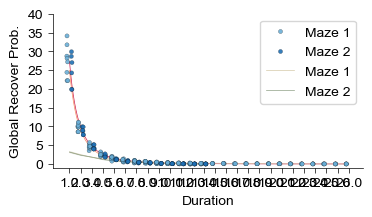

C:\Users\12454\AppData\Local\Temp\ipykernel_25976\1677697386.py:56: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.lineplot(


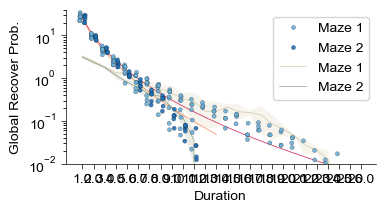

Maze A&B statistic test global recovery.
Day  1
LeveneResult(statistic=22.03417792991767, pvalue=7.5373450227679e-05)
TtestResult(statistic=19.209824595649195, pvalue=6.312765547545683e-11, df=13)
Day  2
LeveneResult(statistic=10.319028385114185, pvalue=0.0034942890642056046)
TtestResult(statistic=24.157665990840943, pvalue=3.4633030769635807e-12, df=13)
Day  3
LeveneResult(statistic=18.094328288573763, pvalue=0.0002405873648295577)
TtestResult(statistic=16.807680544509164, pvalue=3.365864980573501e-10, df=13)
Day  4
LeveneResult(statistic=1.7807637443168152, pvalue=0.19362560836680165)
TtestResult(statistic=12.218649689611794, pvalue=1.682308763842643e-08, df=13)
Day  5
LeveneResult(statistic=0.17935079378105268, pvalue=0.6754146506419791)
TtestResult(statistic=6.529677723239417, pvalue=1.9130552500545194e-05, df=13)
Day  6
LeveneResult(statistic=0.014807556054379344, pvalue=0.9040830913023563)
TtestResult(statistic=2.7530728629319197, pvalue=0.016441027227556988, df=13)
Day  7
Levene

In [52]:
fig = plt.figure(figsize=(4,2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax.plot(x1-1, y1*100, color=colors[0], linewidth = 0.5)
ax.plot(x2-1, y2*100, color=colors[1], linewidth = 0.5)
sns.stripplot(
    x = 'Duration',
    y = 'Global Recover Prob.',
    data=SubData,
    hue = "Maze Type",
    hue_order=['Maze 1', 'Maze 2'],
    palette = markercolors,
    edgecolor='black',
    size=3,
    linewidth=0.15,
    alpha=0.9,
    jitter=0.1,
    dodge=True,
    ax = ax
)
sns.lineplot(
    x = ShufData['Duration']-1,
    y = ShufData['Global Recover Prob.'],
    data=ShufData,
    hue=ShufData['Maze Type'],
    palette=chancecolors,
    err_kws={"edgecolor": None},
    linewidth = 0.5,
    ax = ax
)
ax.set_ylim(-1, 40)
ax.set_yticks(np.linspace(0, 40, 9))

plt.savefig(join(loc, 'Global recover prob.png'), dpi = 600)
plt.savefig(join(loc, 'Global recover prob.svg'), dpi = 600)
plt.show()

fig = plt.figure(figsize=(4,2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax.plot(x1-1, y1*100, color=colors[0], linewidth = 0.5)
ax.plot(x2-1, y2*100, color=colors[1], linewidth = 0.5)
sns.stripplot(
    x = 'Duration',
    y = 'Global Recover Prob.',
    data=SubData,
    hue = "Maze Type",
    hue_order=['Maze 1', 'Maze 2'],
    palette = markercolors,
    edgecolor='black',
    size=3,
    linewidth=0.15,
    alpha=0.9,
    jitter=0.1,
    dodge=True,
    ax = ax
)
sns.lineplot(
    x = ShufData['Duration']-1,
    y = ShufData['Global Recover Prob.'],
    data=ShufData,
    hue=ShufData['Maze Type'],
    palette=chancecolors,
    err_kws={"edgecolor": None},
    linewidth = 0.5,
    ax = ax
)
ax.semilogy()
ax.set_ylim(0.01, 40)

plt.savefig(join(loc, 'Global recover prob [semilogy].png'), dpi = 600)
plt.savefig(join(loc, 'Global recover prob [semilogy].svg'), dpi = 600)
plt.show()
print("Maze A&B statistic test global recovery.")
for i in range(1, 14):
    print("Day ", i)
    print(levene(SubData['Global Recover Prob.'][np.where(SubData['Duration'] == i)[0]], 
                ShufData['Global Recover Prob.'][np.where(ShufData['Duration'] == i)[0]]))
    try:
        print(ttest_rel(SubData['Global Recover Prob.'][np.where(SubData['Duration'] == i)[0]], 
                    ShufData['Global Recover Prob.'][np.where(ShufData['Duration'] == i)[0]]))
    except:
        pass

# Global Recovery Proportion for Hairpin & Reverse Maze (Fig. 3D)

In [53]:
# Global Recovery Prob. Hairpin
idx = np.where((Data['Paradigm'] != 'CrossMaze')&
               (np.isnan(Data['Global Recover Prob.']) == False)&
               (Data['Type'] == 'Real'))[0]
SubData = SubDict(Data, Data.keys(), idx=idx)

idx = np.where((Data['Paradigm'] != 'CrossMaze')&
               (np.isnan(Data['Global Recover Prob.']) == False)&
               (Data['Type'] == 'Shuffle'))[0]
ShufData = SubDict(Data, Data.keys(), idx=idx)


# Fit parameters
bounds = [[0, 0, 0], [np.inf, np.inf, 1]]
initial_guesses = [1, 1, 0.5]
idx = np.where(SubData['Paradigm'] == 'HairpinMaze cis')[0]
params1, _ = curve_fit(lambda x, b, c: kww_decay(x, 5, b, c), SubData['Duration'][idx], 
                       SubData['Global Recover Prob.'][idx]/100, p0=[0.05, 0.4])
x1 = np.linspace(min(SubData['Duration'][idx]), max(SubData['Duration'][idx]), 10000)
print(params1)
y1 = kww_decay(x1, 5, *params1)

idx = np.where(SubData['Paradigm'] == 'HairpinMaze trs')[0]
params2, _ = curve_fit(lambda x, b, c: kww_decay(x, 5, b, c), SubData['Duration'][idx], 
                       SubData['Global Recover Prob.'][idx]/100, p0=[0.05, 0.4])
x2 = np.linspace(min(SubData['Duration'][idx]), max(SubData['Duration'][idx]), 10000)
print(params2)
y2 = kww_decay(x2, 5, *params2)

idx = np.where(SubData['Paradigm'] == 'ReverseMaze cis')[0]
params3, _ = curve_fit(lambda x, b, c: kww_decay(x, 5, b, c), SubData['Duration'][idx], 
                       SubData['Global Recover Prob.'][idx]/100, p0=[0.05, 0.4])
x3 = np.linspace(min(SubData['Duration'][idx]), max(SubData['Duration'][idx]), 10000)
print(params3)
y3 = kww_decay(x3, 5, *params3)

idx = np.where(SubData['Paradigm'] == 'ReverseMaze trs')[0]
params4, _ = curve_fit(lambda x, b, c: kww_decay(x, 5, b, c), SubData['Duration'][idx], 
                       SubData['Global Recover Prob.'][idx]/100, p0=[0.05, 0.4])
x4 = np.linspace(min(SubData['Duration'][idx]), max(SubData['Duration'][idx]), 10000)
print(params4)
y4 = kww_decay(x4, 5, *params4)

colors = ['#6D9BA8', '#A3CBB2', '#E9D985', '#D57A66']

[0.07375384 0.45946461]
[0.05933831 0.43244119]
[0.0879279 0.4700667]
[0.07465055 0.44891384]


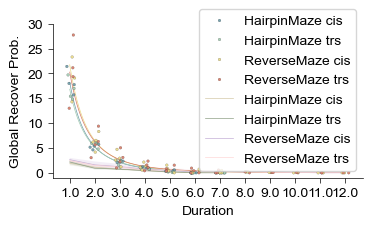

All test
Day  1
TtestResult(statistic=14.60233546810207, pvalue=2.83502792759467e-10, df=15)
Day  2
TtestResult(statistic=15.479657704012094, pvalue=1.243806581670175e-10, df=15)
Day  3
TtestResult(statistic=6.862689168121625, pvalue=5.389592230285645e-06, df=15)
Day  4
TtestResult(statistic=10.759145878129805, pvalue=1.8923659733394314e-08, df=15)
Day  5
TtestResult(statistic=2.6498973152121787, pvalue=0.018195095028744838, df=15)
Day  6
TtestResult(statistic=2.035111486983397, pvalue=0.05990820648105821, df=15)
Day  7
TtestResult(statistic=-0.9735859908453187, pvalue=0.34570199345524555, df=15)
Day  8
TtestResult(statistic=-1.2865092625542018, pvalue=0.28855569715648843, df=3)
Day  9
TtestResult(statistic=-1.7287812715524258, pvalue=0.18229211270140067, df=3)
Day  10
TtestResult(statistic=-0.659714676687874, pvalue=0.5565614431548246, df=3)



In [57]:
fig = plt.figure(figsize=(4, 2))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
ax.plot(x1-1, y1*100, color=colors[0], linewidth = 0.5)
ax.plot(x2-1, y2*100, color=colors[1], linewidth = 0.5)
ax.plot(x3-1, y3*100, color=colors[2], linewidth = 0.5)
ax.plot(x4-1, y4*100, color=colors[3], linewidth = 0.5)
sns.stripplot(
    x = 'Duration',
    y = 'Global Recover Prob.',
    data=SubData,
    hue = "Paradigm",
    hue_order=['HairpinMaze cis', 'HairpinMaze trs', 'ReverseMaze cis', 'ReverseMaze trs'],
    palette = colors,
    edgecolor='black',
    size=2,
    linewidth=0.1,
    alpha=0.9,
    ax = ax,
    jitter=0.2
)
sns.lineplot(
    x = ShufData['Duration']-1,
    y = ShufData['Global Recover Prob.'],
    hue = ShufData['Paradigm'],
    hue_order=['HairpinMaze cis', 'HairpinMaze trs', 'ReverseMaze cis', 'ReverseMaze trs'],
    palette = chancecolors,
    linewidth = 0.5,
    err_kws={"edgecolor": None},
    ax = ax
)
ax.set_ylim(-1, 30)
ax.set_yticks(np.linspace(0, 30, 7))

plt.savefig(join(loc, '[Hairpin&Reverse] Global recover prob.png'), dpi = 600)
plt.savefig(join(loc, '[Hairpin&Reverse] Global recover prob.svg'), dpi = 600)
plt.show()

print("All test")
for i in range(1, 11):
    print("Day ",i)
    print(ttest_rel(SubData['Global Recover Prob.'][np.where((SubData['Duration'] == i))[0]],
                    ShufData['Global Recover Prob.'][np.where((SubData['Duration'] == i))[0]]))
print()